# Modeling UMAP full data

The metric chosen metric for this evaluation is F1-Score because both classes have the same weight

## Preparing environment

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

C:\Users\WILLIAM\AppData\Local\Temp\ipykernel_8972\1524527445.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


## Importing data

In [2]:
train_df = pd.read_csv(paths.data_processed_dir('train_umap_full.csv'))
test_df = pd.read_csv(paths.data_processed_dir('test_umap_full.csv'))

In [3]:
# Saving id_colaborador for submission

id_col = test_df['id_colaborador']

In [4]:
y = train_df['abandono_6meses']

In [5]:
# Dropping unnecessary columns

X = train_df.drop(columns=['abandono_6meses'])
X_test = test_df.drop(columns=['id_colaborador'])

## Preparing cross validation

In [6]:
# Folding data

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Evaluating XGBoost Model

In [7]:
# Creating base model

xgb_base = XGBClassifier(random_state=42, eval_metric='mlogloss')

In [8]:
# Making cross-validation in xgboost

cv_results = cross_val_score(xgb_base, X, y, cv=kf, scoring='f1')
cv_results

array([0.53465347, 0.54308094, 0.54081633, 0.49717514, 0.55392157])

Initial f1 results are not that good, let's optimize the model with cross-validation

In [9]:
# Defining param grid

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

In [10]:
# Defining random search

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    scoring=make_scorer(f1_score),
    n_iter=100,  # Number of different combinations to try
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [11]:
# Optimizing model

random_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_t...
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring=make_scorer(f1_score), verbose=2)

In [12]:
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation F1 score: {random_search.best_score_}")

Best parameters found: {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best cross-validation F1 score: 0.5408175067406908


## Evaluating neural network

Defining optimization function

In [13]:
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu', input_dim=X.shape[1]))
        model.add(Dropout(hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        return model

In [14]:
# Setting F1 Score as a default metric

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype(int)
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        print(f' — val_f1: {_val_f1}')
        logs['val_f1'] = _val_f1

# Include the custom callback in the tuner search
f1_callback = F1ScoreCallback(validation_data=(X, y))

In [15]:
# Setup Keras Tuner to find the best hyperparameters:

from kerastuner.tuners import RandomSearch

# Define the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='..\keras_tuner_3',
    project_name='binary_classification'
)

In [16]:
# Search for best hyperparameters
tuner.search(X, y, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5), f1_callback])

Trial 20 Complete [00h 00m 13s]
val_accuracy: 0.46867749094963074

Best val_accuracy So Far: 0.5050270756085714
Total elapsed time: 00h 04m 10s


In [17]:
# Retrieve the best model

best_model = tuner.get_best_models(num_models=1)[0]

In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [19]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and the optimal number of units in the second densely-connected layer is {best_hps.get('units2')}.
The best dropout rates are {best_hps.get('dropout1')} and {best_hps.get('dropout2')}.
The best learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal number of units in the second densely-connected layer is 224.
The best dropout rates are 0.4 and 0.4.
The best learning rate for the optimizer is 0.0013263444829043885.



Cross validation

In [20]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    return best_model

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

# Define a custom F1 score metric for cross-validation
f1_scorer = make_scorer(f1_score)

# Perform cross-validation with F1 score
scores = cross_val_score(model, X, y, cv=5, scoring=f1_scorer)

print(f"Cross-validation F1 scores: {scores}")
print(f"Mean cross-validation F1 score: {scores.mean()}")

C:\Users\WILLIAM\AppData\Local\Temp\ipykernel_8972\3049308793.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=0)


14/14 [==============================] - 0s 1ms/step
Cross-validation F1 scores: [0.17777778 0.12444444 0.35099338 0.3161512  0.27826087]
Mean cross-validation F1 score: 0.24952553440400482


The neural network had better results than XGBoost and SVC. Let's evaluate them on test data

## Evaluating best models

### XGBoost

In [21]:
best_xgboost = XGBClassifier(random_state=42, eval_metric='mlogloss',
                             subsample=0.6, n_estimators=400,
                             min_child_weight=3, max_depth=5, learning_rate=0.1,
                             gamma=0.5, colsample_bytree=1.0)

In [22]:
# Fitting the model 

best_xgboost.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [23]:
# Predicting values

y_pred_xgb = best_xgboost.predict(X_test)

In [24]:
# Saving predicted values

sub_xgb = pd.DataFrame(y_pred_xgb, columns=['abandono_6meses'])
sub_xgb = pd.concat([id_col, sub_xgb], axis=1)
sub_xgb.rename(columns={'id_colaborador': 'ID'}, inplace=True)
sub_xgb.to_csv('../results/sub_xgb_umap_full.csv', index=False, sep=',')

Kaggle Score:

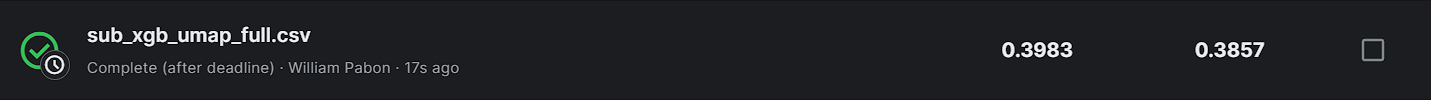

### Neural Network

In [25]:
best_model.fit(X, y, epochs=50, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5), f1_callback])

Epoch 1/50
68/68 [==============================] - 0s 888us/steposs: 0.6613 - accuracy: 0.
 — val_f1: 0.1956709956709957
108/108 [==============================] - 1s 6ms/step - loss: 0.6614 - accuracy: 0.6037 - val_loss: 0.7407 - val_accuracy: 0.4246 - val_f1: 0.1957
Epoch 2/50
68/68 [==============================] - 0s 970us/steposs: 0.6647 - accuracy: 0.
 — val_f1: 0.1918047079337402
108/108 [==============================] - 0s 4ms/step - loss: 0.6644 - accuracy: 0.6049 - val_loss: 0.7429 - val_accuracy: 0.4200 - val_f1: 0.1918
Epoch 3/50
68/68 [==============================] - 0s 849us/steposs: 0.6638 - accuracy: 0.
 — val_f1: 0.21043627031650983
108/108 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.5915 - val_loss: 0.7473 - val_accuracy: 0.4316 - val_f1: 0.2104
Epoch 4/50
68/68 [==============================] - 0s 888us/steposs: 0.6652 - accuracy: 0.
 — val_f1: 0.20836891545687447
108/108 [==============================] - 1s 5ms/step - loss: 0.6

In [26]:
# Predicting values

y_pred_nn = (best_model.predict(X_test) > 0.5).astype(int)

64/64 [==============================] - 0s 913us/step


In [27]:
# Saving predicted values

sub_nn = pd.DataFrame(y_pred_nn, columns=['abandono_6meses'])
sub_nn = pd.concat([id_col, sub_nn], axis=1)
sub_nn.rename(columns={'id_colaborador': 'ID'}, inplace=True)
sub_nn.to_csv('../results/sub_nn_umap_full.csv', index=False, sep=',')

Kaggle Score:

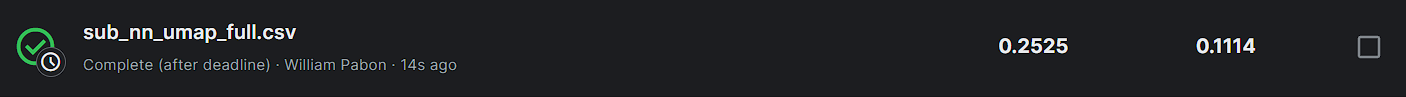